<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="cognitiveclass.ai logo">
</center>


# Machine Learning Foundation

## Course 4, Part b: Distance and the Curse of Dimensionality DEMO


Estimated time needed: **45** minutes


In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import seaborn as sns, pandas as pd, numpy as np

In [2]:
from matplotlib import pyplot as plt
import numpy as np

# Curse of Dimensionality 

### DEMO objectives: 
* Gain understanding of why observations are far apart in high-dimensional space
* See an example of how adding dimensions degrades model performance for classification
* Learn how to fight the curse of dimensionality in your modeling projects

-----

### In high-dimensional space, points tend to be far apart.
This impacts data analysis. Intuitively, clustering is difficult when points are far away from each other: If my next nearest neighbor is very far away, does it still make sense to call it my neighbor? This notebook will show why high-dimensional space leads to sparse data. 


### A circle inside a square 

Let's start by drawing a unit circle inside of a square. 


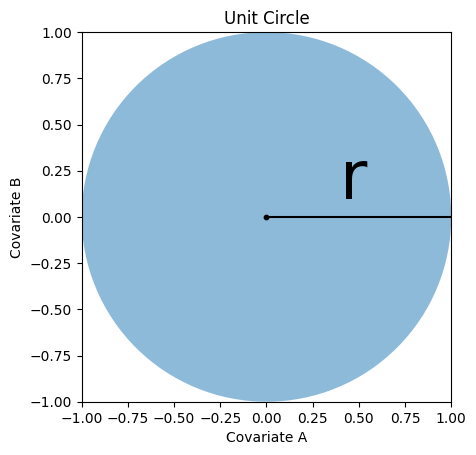

In [3]:
def make_circle(point=0):
    fig = plt.gcf()
    ax = fig.add_subplot(111, aspect='equal')
    fig.gca().add_artist(plt.Circle((0,0),1,alpha=.5))
    ax.scatter(0,0,s=10,color="black")
    ax.plot(np.linspace(0,1,100),np.zeros(100),color="black")
    ax.text(.4,.1,"r",size=48)
    ax.set_xlim(left=-1,right=1)
    ax.set_ylim(bottom=-1,top=1)
    plt.xlabel("Covariate A")
    plt.ylabel("Covariate B")
    plt.title("Unit Circle")
    
    if point:
        ax.text(.55,.9,"Far away",color="purple")
        ax.scatter(.85,.85,s=10,color="purple")
    else: 
        plt.show()
    
make_circle()

Each axis is a different covariate. Imagine we've standard scaled our data, so they're centered on zero. This means that the average for each covariate is now zero, or the center of our circle. Points that our outside the unit circle would be harder to classify because the values of their covariates are far from the mean. 


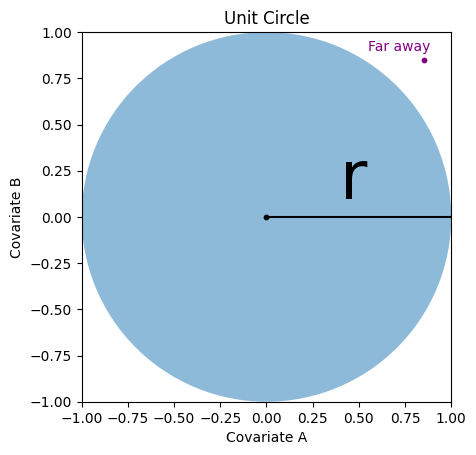

In [4]:
make_circle(1)

### How much of the square is outside the circle? And the cube outside the sphere, etc.

We've concluded that our purple point above would be hard to classify because it's far away from the rest of our observations. But what percentage of our points in the square are outside of the circle, and thus "far away"? Let's do some math!

Since the square has length $2r$ and area $(2r)^2$, the percentage of the square outside the circle is:  1 - $\frac {\pi r^2} {(2r)^2} = 1 - \frac \pi 4$ = ~ 21% 

But what about a cube? To illustrate, we will use [matplotlib's 3-D axis](https://matplotlib.org/3.2.1/api/_as_gen/mpl_toolkits.mplot3d.axes3d.Axes3D.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork821-2023-01-01) which allows the '3d' projection, as well as the [itertools](https://docs.python.org/3/library/itertools.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork821-2023-01-01) library, which offers a number of efficient tools for looping and combining lists. We will use the [product](https://docs.python.org/2/library/itertools.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork821-2023-01-01#itertools.product) (cartesian product) and [combinations](https://docs.python.org/2/library/itertools.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork821-2023-01-01#itertools.combinations) (unique subsequences) functions. 


In [15]:
list(product([1,2],[3,4],[5,6])) # every possible combination of these numbers, no order

[(1, 3, 5),
 (1, 3, 6),
 (1, 4, 5),
 (1, 4, 6),
 (2, 3, 5),
 (2, 3, 6),
 (2, 4, 5),
 (2, 4, 6)]

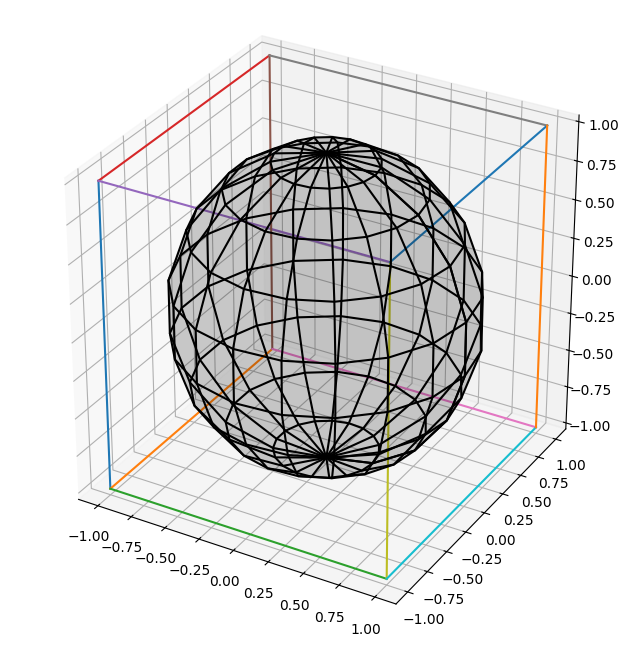

In [14]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from itertools import product, combinations

# Create figure 
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect("equal")

# Draw cube
r = [-1, 1]
for s, e in combinations(np.array(list(product(r,r,r))), 2):
    if np.sum(np.abs(s-e)) == r[1]-r[0]:
        ax.plot3D(*zip(s,e))

# Draw sphere on same axis 
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x=np.cos(u)*np.sin(v)
y=np.sin(u)*np.sin(v)
z=np.cos(v)
ax.plot_surface(x, y, z, color="black", alpha=0.1)
ax.plot_wireframe(x, y, z, color="black");

The volume of the sphere is given by the forumula: $\frac{4}{3} \pi r^3$, and since the cube has a radius of $2r$, it has volume $(2r)^3$. 

This allows us to calculate the percent of the cube's volume that's outside of the sphere: 1- $\frac {\frac 4 3 \pi r^3} {(2r)^3} = 1 - \frac \pi 6$ = ~ 48%

### Can we generalize to more than three dimensions? 

Let's draw a bunch of random points from a 0-1 distribution, then measure how far away from the origin they are. 


In [21]:
# Draw a sample of data in two dimensions
sample_data = np.random.sample((5,2))
print("Sample data:\n", sample_data, '\n')

def norm(x): # euclidean distance from (0,0)
    ''' Measure the distance of each point from the origin.
    
    Input: Sample points, one point per row
    Output: The distance from the origin to each point
    '''
    return np.sqrt( (x**2).sum(1) ) # np.sum() sums an array over a given axis 

def in_the_ball(x): 
    ''' Determine if the sample is in the circle. 
    
    Input: Sample points, one point per row
    Output: A boolean array indicating whether the point is in the ball
    '''
    return norm(x) < 1 # If the distance measure above is <1, we're inside the ball


for x, y in zip(norm(sample_data),in_the_ball(sample_data)):
    print("Norm = ", x.round(2), "; is in circle? ", y)

Sample data:
 [[0.07521411 0.32125205]
 [0.73525907 0.64843545]
 [0.04749511 0.69331939]
 [0.08067132 0.10568089]
 [0.68449034 0.9626075 ]] 

Norm =  0.33 ; is in circle?  True
Norm =  0.98 ; is in circle?  True
Norm =  0.69 ; is in circle?  True
Norm =  0.13 ; is in circle?  True
Norm =  1.18 ; is in circle?  False


Can we generalize beyond two dimensions? 


In [24]:
def what_percent_of_the_ncube_is_in_the_nball(d_dim,
                                              sample_size=10**4):
    shape = sample_size,d_dim
    data = np.array([in_the_ball(np.random.sample(shape)).mean()
                     for iteration in range(100)])
    return data.mean()

dims = range(2,15)
data = np.array(list(map(what_percent_of_the_ncube_is_in_the_nball,dims)))


for dim, percent in zip(dims,data):
    print("Dimension = ", dim, "; percent in ball = ", percent)

Dimension =  2 ; percent in ball =  0.785766
Dimension =  3 ; percent in ball =  0.523803
Dimension =  4 ; percent in ball =  0.308135
Dimension =  5 ; percent in ball =  0.16436
Dimension =  6 ; percent in ball =  0.080998
Dimension =  7 ; percent in ball =  0.037055000000000005
Dimension =  8 ; percent in ball =  0.015952
Dimension =  9 ; percent in ball =  0.006466999999999998
Dimension =  10 ; percent in ball =  0.002374
Dimension =  11 ; percent in ball =  0.0009070000000000001
Dimension =  12 ; percent in ball =  0.00031600000000000004
Dimension =  13 ; percent in ball =  0.00011700000000000002
Dimension =  14 ; percent in ball =  3.5000000000000004e-05


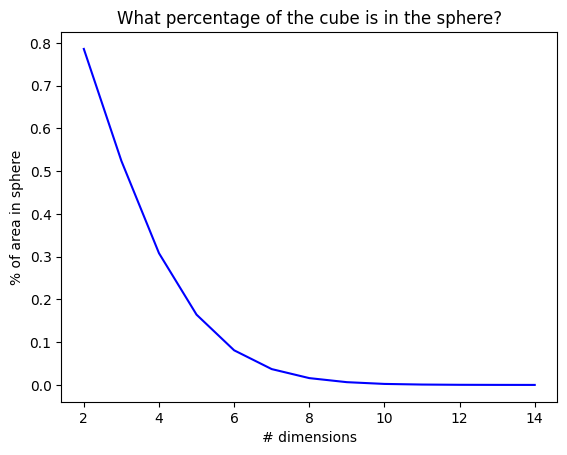

In [25]:
# Let's plot the above percentages 

plt.plot(dims, data, color='blue')
plt.xlabel("# dimensions")
plt.ylabel("% of area in sphere")
plt.title("What percentage of the cube is in the sphere?")
plt.show()

## Check for understanding

What happens to the percentage of the area in the sphere as we increase the number of dimensions? What does this mean about how the dispersion of our data? 

---


### Measuring the distance from the center of the cube to the nearest point

Let's continue with our drawing of random points in the cube. This time, we'll draw a bunch of points, then measure the distance of all the points to the center of the cube to see how close the closest point is to the center. 

If we find out that the closest point is far from the center in high dimensions, that gives us more evidence that increasing dimensions will make it harder to classify our data properly. 


In [26]:
def get_min_distance(dimension, sample_size=10**3):
    ''' Sample some random points and find the closet 
    of those random points to the center of the data '''
    points = np.random.sample((sample_size,dimension))-.5   # centering our data
    return np.min(norm(points))

def estimate_closest(dimension):
    ''' For a given dimension, take a random sample in that dimension and then find 
        that sample's closest point to the center of the data. 
        Repeat 100 times for the given dimension and return the min/max/mean 
        of the distance for the nearest point. '''
    data = np.array([get_min_distance(dimension) for _ in range(100)])
    return data.mean(), data.min(), data.max()

# Calculate for dimensions 2-100
dims = range(2,100)
min_distance_data = np.array(list(map(estimate_closest,dims)))

# Test it for dimension 6
print("For dimension 6: ", estimate_closest(6))

For dimension 6:  (0.23191646205180183, 0.10596422389102632, 0.31515566083600033)


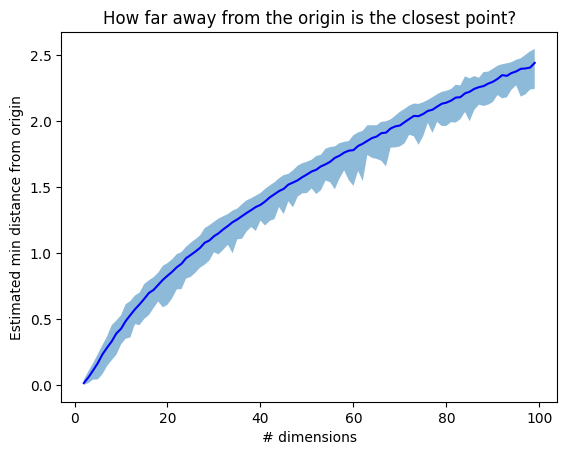

In [27]:
# Plot the min/max/mean of the closest point for each dimension using sampling 

plt.plot(dims,min_distance_data[:,0], color='blue')
plt.fill_between(dims, min_distance_data[:,1], min_distance_data[:,2],alpha=.5)
plt.xlabel("# dimensions")
plt.ylabel("Estimated min distance from origin")
plt.title("How far away from the origin is the closest point?"); 

## Check for understanding

What would we have to do to get similar density of points as the low dimensions if we wanted to use higher dimensions of data? 

---


### How to fight the curse of dimensionality 

The curse of dimensionality is a common hurdle in real-world predictive modeling. We've already seen this in our bag-of-words approach to NLP. How can we create good models in cases where our data is of high dimensionality? 

* Feature selection: Use domain knowledge to reduce the number of features included in the model
* Feature extraction: Use dimensionality reduction techniques (e.g. PCA) to transform the raw data into a lower number of features that preserve (most of) the variability in the data

We'll talk more about PCA next.


## How does high dimensionality affect model performance?

We'll test model performance (classification accuracy) by creating some random data for classification, one set with a low number of features and another with a very high number of features. We'll then compare their performance using the same classification algorithm. 


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier

In [29]:
# Create a dataset with two features 

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=2)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)

X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)

In [30]:
DT =  DecisionTreeClassifier()
DT.fit(X_train, y_train)
score = DT.score(X_test, y_test)

In [31]:
print("Score from two-feature classifier: ", score)

Score from two-feature classifier:  0.875


In [35]:
# Now do the same thing but with 200 features 

X, y = make_classification(n_features=200, n_redundant=0, n_informative=200,
                           random_state=1, n_clusters_per_class=2)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)

X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)

DT =  DecisionTreeClassifier()
DT.fit(X_train, y_train)
score = DT.score(X_test, y_test)

In [36]:
print("Score from 200-feature classifier: ", score)

Score from 200-feature classifier:  0.55


Here we see that adding additional features, even if informative, can lead to worse model performance (due to increased overfitting of training data.


### Comparing accuracy of classification against number of features

Let's see what happens if we keep adding features to our classification problem. We'll hold the number of classes at three in order to see how the curse of dimensionality hurts our model performance. 


In [37]:
scores = []

increment, max_features = 50, 4000

for num in np.linspace(increment, max_features, increment, dtype='int'):

    X, y = make_classification(n_features=num, n_redundant=0, 
                               random_state=1, n_clusters_per_class=1, n_classes = 3)
    rng = np.random.RandomState(2)
    X += 2 * rng.uniform(size=X.shape)

    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)

    
    DT =  DecisionTreeClassifier()
    DT.fit(X_train, y_train)
    scores.append( DT.score(X_test, y_test) )


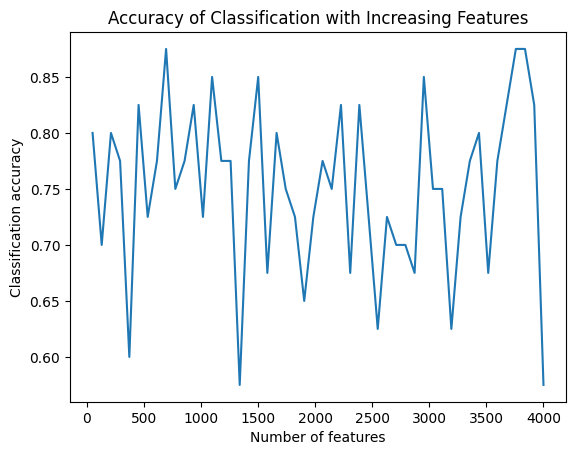

In [38]:
plt.plot(np.linspace(increment, max_features, increment, dtype='int'),scores)
plt.title("Accuracy of Classification with Increasing Features")
plt.xlabel("Number of features")
plt.ylabel("Classification accuracy");

As we can see from the chart, adding features can lead to reductions in accuracy -- in this example accuracy is highly volatile in the number of features, and increasing features can reduce accuracy. Additionally, in our example, we specified that none of the features are redundnant (`n_redundant=0`). In practice, the situation is often worse as several of the features may be either redundant or not relevant. For example, if we are predicting customer churn using a variety of customer characteristics, we may have collected extensive data for each customer across many dimensions. This is an example of high-dimensional, which can make it difficult to apply unsupervised learning methods directly and potentially to lead to issues with the curse of dimensionality.

---
### Machine Learning Foundation (C) 2020 IBM Corporation
